# Math 164 Project

#### By Jonathan Liesch 704958918

## Solving Markowitz using Stacking

In Breiman’s paper, he states is this method for stacking gives consistently good results:

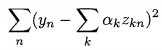

This can be solved using least squares.

### Solving using Least Squares

The desired monthly return in 1.4951%.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ebay = pd.read_csv("C:/Stacking/EBAY.csv")
nvs = pd.read_csv("C:/Stacking/NVS.csv")
ebay = ebay[['Date', 'Adj Close']]
nvs = nvs[['Date', 'Adj Close']]

ebayReturns = []
nvsReturns = []

for i in range(len(ebay.index)-1):
    ebay_ret = (ebay.at[i+1,'Adj Close']/ebay.at[i,'Adj Close']) - 1
    ebayReturns.append(ebay_ret)

    nvs_ret = (nvs.at[i + 1, 'Adj Close'] / nvs.at[i, 'Adj Close']) - 1
    nvsReturns.append(nvs_ret)

ebay = ebay.drop(index =0, columns = ['Adj Close'] )
ebay['EBAY'] = ebayReturns
ebay_ret = ebay['EBAY'].values

nvs = nvs.drop(index = 0, columns = ['Adj Close'])
nvs['NVS'] = nvsReturns
nvs_ret = nvs['NVS'].values

v1 = ebay_ret
v2 = nvs_ret

p_ret = 0.014941

b = np.full(120, p_ret)

Z_list = []
for i in range(120):
    v1n = np.delete(v1, i)
    v2n = np.delete(v2, i)

    z1n = np.mean(v1n)
    z2n = np.mean(v2n)
    z = [z1n, z2n]
    Z_list.append(z)

Z = np.asarray(Z_list)

LS = np.matmul(Z.T,Z)
LS_inv = np.linalg.inv(LS)
LS_b = np.matmul(Z.T, b)

weights = np.matmul(LS_inv,LS_b)
print(weights)

[0.4322291  0.62075537]


There is one issue with this method. The weights do not sum up to 1! Thus this variant of stacking would not be feasible for Markowitz.

In [6]:
print(np.sum(weights))

1.0529844692326833


## Solving using Lagragian Multipliers (Better)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ebay = pd.read_csv("C:/Stacking/EBAY.csv")
nvs = pd.read_csv("C:/Stacking/NVS.csv")
ebay = ebay[['Date', 'Adj Close']]
nvs = nvs[['Date', 'Adj Close']]

ebayReturns = []
nvsReturns = []

for i in range(len(ebay.index)-1):
    ebay_ret = (ebay.at[i+1,'Adj Close']/ebay.at[i,'Adj Close']) - 1
    ebayReturns.append(ebay_ret)

    nvs_ret = (nvs.at[i + 1, 'Adj Close'] / nvs.at[i, 'Adj Close']) - 1
    nvsReturns.append(nvs_ret)

ebay = ebay.drop(index =0, columns = ['Adj Close'] )
ebay['EBAY'] = ebayReturns
ebay_ret = ebay['EBAY'].values

nvs = nvs.drop(index = 0, columns = ['Adj Close'])
nvs['NVS'] = nvsReturns
nvs_ret = nvs['NVS'].values

v1 = ebay_ret
v2 = nvs_ret

avg_ret = [np.mean(v1), np.mean(v2)]

alpha = np.asarray(avg_ret)

p_ret = 0.014941

sigma = np.cov(v1,v2)
s_inv = np.linalg.inv(sigma)
a = np.matmul(alpha.T, np.matmul(s_inv, alpha))
one_m = np.full(2,1)
b = np.matmul(alpha.T, np.matmul(s_inv, one_m))
c = np.matmul(one_m.T, np.matmul(s_inv, one_m))

mat = np.array([[a, b],[b,c]])
mat_inv = np.linalg.inv(mat)
y = np.array([[p_ret, 1]])

L_mult = np.matmul(y, mat_inv)

weights = L_mult[0,0] * np.matmul(s_inv, alpha) + L_mult[0,1] * np.matmul(s_inv, one_m)

print(weights)
print('Sum:', np.sum(weights))

[0.50000456 0.49999544]
Sum: 1.0000000000000004


Since the weights sum to one, this is clearly an applicable to Markowitz over the non-negativity way proposed by Breiman.

# Solving Risk-Parity using Stacking

To try to solve the stacking problem with the added contraint of summing the weights to one, Breiman found:

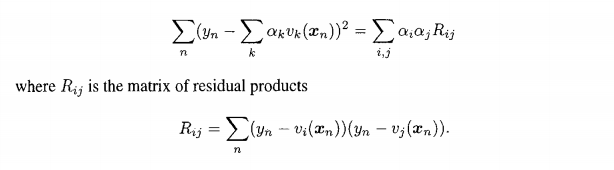

Thus the weights would minimize with the added one sum contraint:

This happens to be very convienent to solving for the weights for Risk-Parity.

It should be noted that cross-validation data is not used to determine the weights. Thus, it is more different than an added contraint to the stacking problem we did for the Markowitz Selection.

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize


ebay = pd.read_csv("C:/Stacking/EBAY.csv")
nvs = pd.read_csv("C:/Stacking/NVS.csv")
ebay = ebay[['Date', 'Adj Close']]
nvs = nvs[['Date', 'Adj Close']]

ebayReturns = []
nvsReturns = []

for i in range(len(ebay.index)-1):
    ebay_ret = (ebay.at[i+1,'Adj Close']/ebay.at[i,'Adj Close']) - 1
    ebayReturns.append(ebay_ret)

    nvs_ret = (nvs.at[i + 1, 'Adj Close'] / nvs.at[i, 'Adj Close']) - 1
    nvsReturns.append(nvs_ret)

ebay = ebay.drop(index =0, columns = ['Adj Close'] )
ebay['EBAY'] = ebayReturns
ebay_ret = ebay['EBAY'].values

nvs = nvs.drop(index = 0, columns = ['Adj Close'])
nvs['NVS'] = nvsReturns
nvs_ret = nvs['NVS'].values

v1 = ebay_ret
v2 = nvs_ret

V = np.cov(v1,v2)

w0 = [0.5,0.5]
x_t = [0.5, 0.5]

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk

    w = np.matrix(x_t)
    port_var = (w * V * w.T)[0, 0]

    sigma =  np.sqrt(port_var) # portfolio sigma
    desired_risk = np.asmatrix(np.multiply(sigma,x_t))
    MRC = V * w.T
    RC = np.multiply(MRC, w.T) / sigma

    J = sum(np.square(RC-desired_risk.T))[0,0] # sum of squared error
    return J

def one_sum(x):
    return np.sum(x)-1.0

def nonnegativity(x):
    return x

constraints = ({'type': 'eq', 'fun': one_sum},
{'type': 'ineq', 'fun': nonnegativity})
res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=constraints, options={'disp': True})
w_rb = np.asmatrix(res.x)
print(w_rb)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00021040177503019284
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
[[0.5 0.5]]


As you can see we got the desired equal risk contribution of 0.5.